## Charger les packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import sys
from ipywidgets import interact, widgets
import os
import scipy.io.wavfile as wav

%matplotlib inline

In [72]:
PATH = './vowels/vowels'
PATH_OWN = './vowels/claude_jael'

## Lire les fichiers son

Lecture des fichiers .wav donnés et extractions des coefficients de Mel.
Création des 3 tableaux pour les comparaisons demandées :

- Homme vs Femme (voix naturelles uniquement)
- Homme vs Femme (vois naturelles et synthétiques)
- Homme vs Femme vs Enfant (voix naturelles et synthétiques)

In [95]:
from python_speech_features import mfcc

SAMPLE_RATE = 24000

part_1 = []
part_2 = []
part_3 = []
part_4 = []

for f in os.listdir(PATH):
    if(f.endswith(".wav")): #Skip the readme
        # Check for natural/synthetical voice
        type_ns = 1 if (f[0] == 'n') else -1
        
        # Check for adult/kid voice
        type_ak = 1 if (f[1] == 'a') else -1
        
        # Check for male/female voice
        if type_ak == 1:
            type_mf = 1 if f[2] == 'f' else -1
            
        # Group male/female and kids informations
        if type_ak == -1:
            type_mfk = (1,-1,-1) # kid
        else:
            if type_mf == -1:
                type_mfk = (-1,1,-1) # male
            else:
                type_mfk = (-1,-1,1) # female        
            
        
        coefs = mfcc(wav.read(os.path.join(PATH, f))[1], SAMPLE_RATE, nfft=1024)
        coefs_avg = np.average(coefs, axis=0) # Aggregate the values
        
        if type_ns == 1 and type_ak == 1: # Only natural adult voices
            part_1.append(np.append(coefs_avg, type_mf)) # Add gender
        
        if type_ak == 1: # On adult voices. Both natural & synthetical
            part_2.append(np.append(coefs_avg, type_mf)) # Add gender
            
        # All voices
        part_3.append(np.append(coefs_avg, type_mfk)) # Add gender or age
        
for f in os.listdir(PATH_OWN):
    # Check for claude/jael voice
    type_cj = -1 if (f[0] == 'c') else 1 
    
    sample_rate, x_file = wav.read(os.path.join(PATH_OWN, f))
        
    coefs = mfcc(x_file, samplerate=sample_rate, nfft=2048)
    coefs_avg = np.average(coefs, axis=0) # Aggregate the values
    
    part_4.append(np.append(coefs_avg, type_cj))
    
part1_ar = np.array(part_1)
part2_ar = np.array(part_2)
part3_ar = np.array(part_3)
part4_ar = np.array(part_4)
    

print(len(part1_ar))
print(len(part2_ar))
print(len(part3_ar))
print(len(part4_ar))

72
144
360
60


## Importer les algorithmes de MLP (Multi-Layer Perceptron) et Cross-Validation

In [4]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

## Explorer les époques

In [65]:
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 8]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

K = 5
N_TESTS = 10

In [101]:
def explore_epochs(data, n_inputs=13, n_outputs=1, n_neurons=[2,4,8], show_graphs=1, n_epochs=200):
    MSE = np.zeros((len(n_neurons), N_INITS, n_epochs))

    for i_h, h in enumerate(n_neurons):                                     # looping over the number of hidden neurons
        print('Testing', h, 'neurons...')
        nn = mlp.MLP([n_inputs,h,n_outputs], 'tanh')
        for i in np.arange(N_INITS):                                        # looping over the initializations
            nn.init_weights()

            MSE[i_h, i, :] = nn.fit((data[:,0:n_inputs], data[:,n_inputs:n_inputs+n_outputs]),
                                    learning_rate=LEARNING_RATE,
                                    momentum=MOMENTUM,
                                    epochs=n_epochs)
            
    if(show_graphs == 1):
        pl.figure(figsize=(15,4))
        p_count = 0
        for n in np.arange(MSE.shape[0]):
            pl.subplot(1, MSE.shape[0], n+1)
            for i in np.arange(MSE.shape[1]):
                pl.plot(MSE[n,i,:], c='b')
            pl.ylim(0,1)
            pl.xlabel('Epochs')
            pl.ylabel('MSE')
            pl.title(str(n_neurons[n]) + ' neurons')
            pl.grid()
        pl.tight_layout()

In [54]:
def explore_hidden_neurons(data, n_inputs=13, n_outputs=1, n_neurons=[2,4,8], show_graphs=1):
    MSE_train = np.zeros((len(n_neurons), EPOCHS, N_TESTS))
    MSE_test = np.zeros((len(n_neurons), EPOCHS, N_TESTS))

    for i_h, h in enumerate(n_neurons):                                      # looping the number of hidden neurons
        print('Testing', h, 'neurons...')
        nn = mlp.MLP([n_inputs,h,n_outputs], 'tanh')
        for i in np.arange(N_TESTS):                                         # looping the tests
            nn.init_weights()                                                # the network has to be reinitialized before each test
            temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,          # notice that we do not use cv.k_fold_cross_validation
                                                                data,        # but cv.k_fold_cross_validation_per_epoch which
                                                                k=K,         # returns a value of error per each epoch
                                                                learning_rate=LEARNING_RATE,
                                                                momentum=MOMENTUM,
                                                                epochs=EPOCHS)
            # temp1 and temp2 are the training and test error. One value per epoch
            MSE_train[i_h, :, i] = temp1
            MSE_test[i_h, :, i] = temp2
            
    if (show_graphs == 1):
        MSE_train_mean = np.mean(MSE_train, axis=2)
        MSE_test_mean = np.mean(MSE_test, axis=2)
        MSE_train_sd = np.std(MSE_train, axis=2)
        MSE_test_sd = np.std(MSE_test, axis=2)

        v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
        v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

        n_rows = int(np.ceil(len(n_neurons)/3.0))
        pl.figure(figsize=(12,3*n_rows))
        for i_n, n in enumerate(n_neurons):
            pl.subplot(n_rows, min(3, len(n_neurons)), i_n+1)
            pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
            pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
            pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
            pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
            pl.ylim(0.95*v_min,0.5*v_max)
            pl.ylabel('MSE')
            pl.xlabel('Number of epochs')
            pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
            pl.legend()
            pl.grid()
        pl.tight_layout()
        
        # Visualize using confusion matrix like plot
        pl.figure(figsize=(15,8))
        pl.subplot(2,1,1)
        pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
        pl.yticks(np.arange(len(n_neurons)), n_neurons)
        pl.xlabel('Epochs')
        pl.ylabel('Number of hidden Neurons')
        pl.title('Training')
        pl.colorbar()
        pl.subplot(2,1,2)
        pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
        pl.yticks(np.arange(len(n_neurons)), n_neurons)
        pl.xlabel('Epochs')
        pl.ylabel('Number of hidden Neurons')
        pl.title('Test')
        pl.colorbar()
        pl.tight_layout()

In [97]:
def confusion_matrix_kfold(data, n_inputs=13, n_outputs=1, n_neurons=8, n_epochs=100):
    nn = mlp.MLP([n_inputs,n_neurons,n_outputs], 'tanh')

    MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          data,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=n_epochs,
                                                          threshold=0.0)

    print('MSE training: ', MSE_train)
    print('MSE test: ', MSE_test)
    print('Confusion matrix:')
    print(conf_mat)

# Man vs Woman. Use only the natural voices

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...


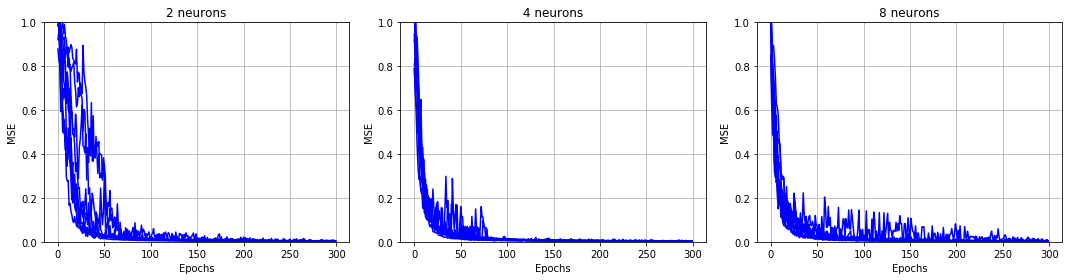

In [102]:
explore_epochs(part1_ar, n_epochs=300)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...


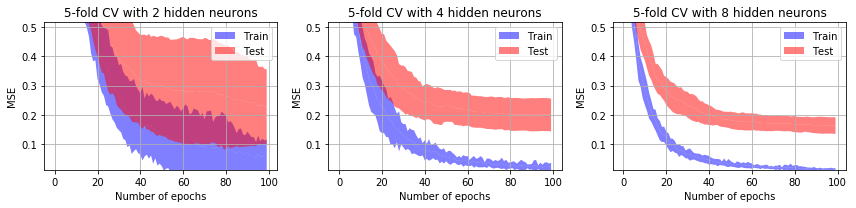

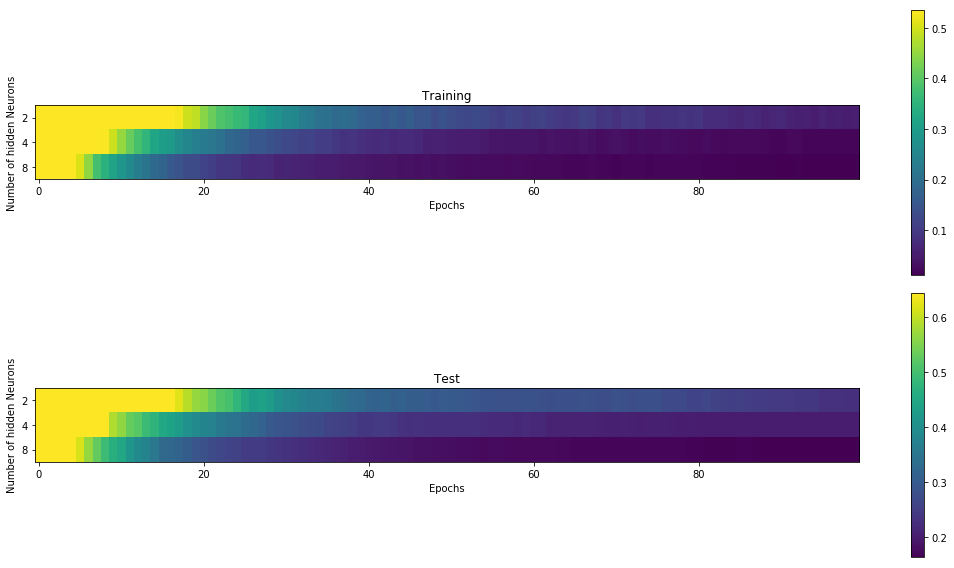

In [57]:
explore_hidden_neurons(part1_ar)

In [103]:
confusion_matrix_kfold(part1_ar, n_epochs=200, n_neurons=8)

MSE training:  0.003777164403497558
MSE test:  0.32401865419593107
Confusion matrix:
[[34.  2.]
 [ 4. 32.]]


# Man vs Woman, using both natural and synthetic voices.

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...


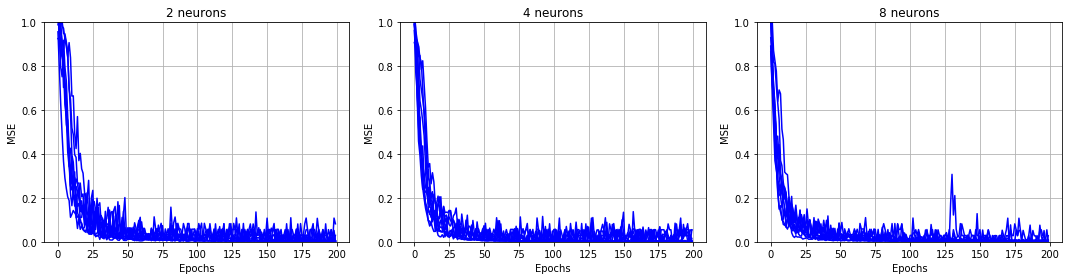

In [105]:
explore_epochs(part2_ar, n_epochs=200)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...


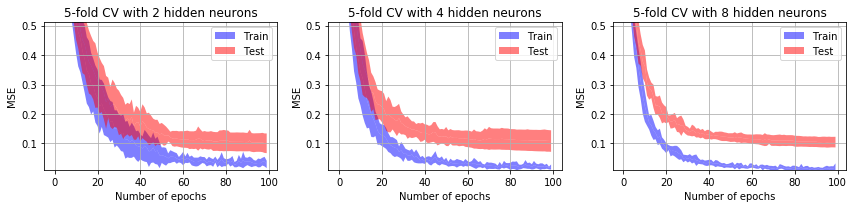

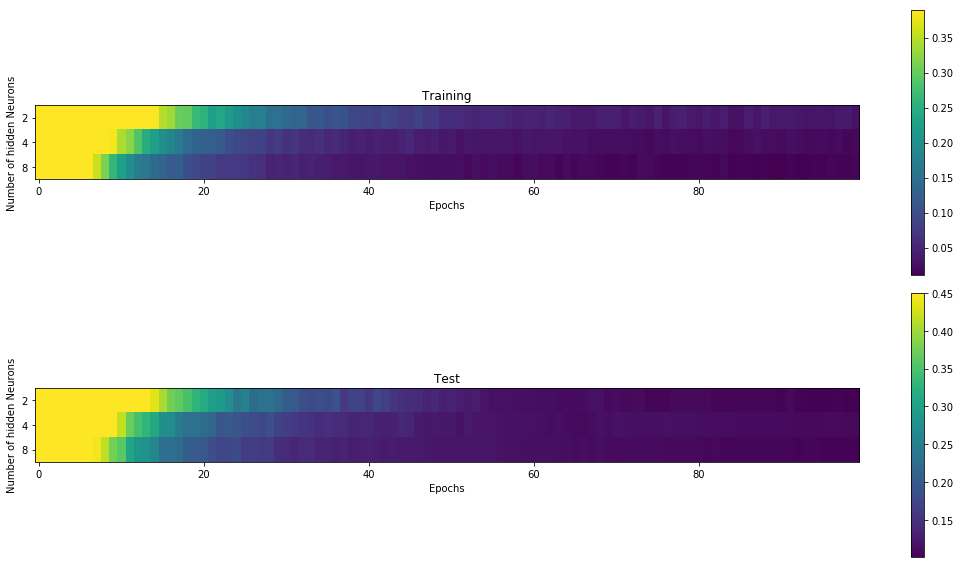

In [42]:
explore_hidden_neurons(part2_ar)

In [106]:
confusion_matrix_kfold(part2_ar, n_epochs=100, n_neurons=4)

MSE training:  0.030071510316207178
MSE test:  0.18028354893861093
Confusion matrix:
[[69.  3.]
 [ 5. 67.]]


# Man vs. Woman vs. children.

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...


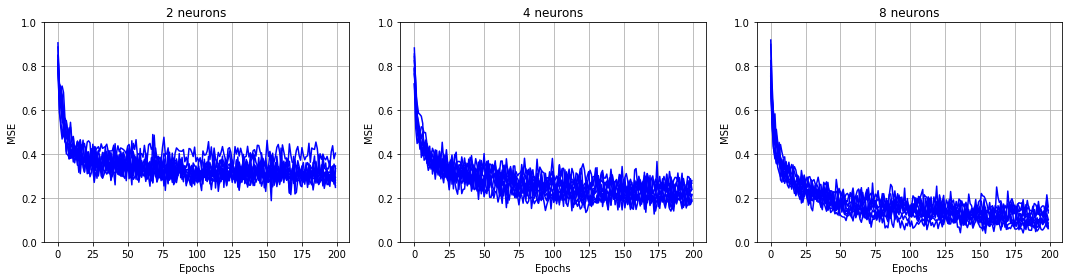

In [69]:
explore_epochs(part3_ar, n_outputs=3)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...


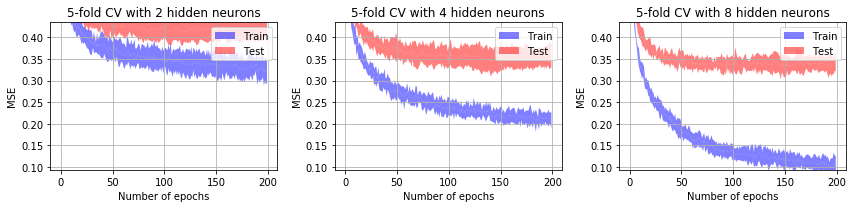

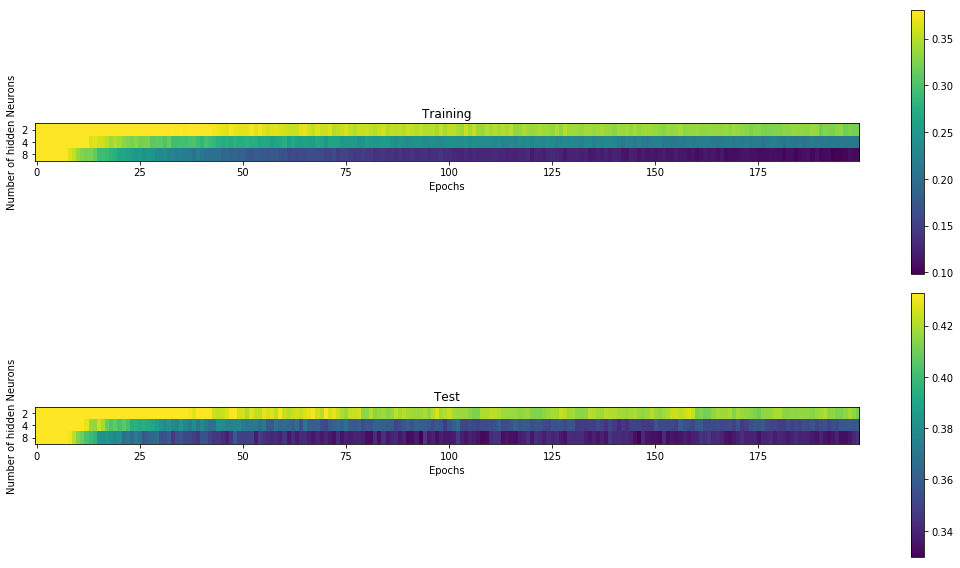

In [70]:
explore_hidden_neurons(part3_ar, n_outputs=3)

In [86]:
confusion_matrix_kfold(part3_ar, n_outputs=3)

MSE training:  0.13542448924677147
MSE test:  0.3489236102176824
Confusion matrix:
[[195.   0.  17.]
 [  2.  67.   5.]
 [ 32.   2.  33.]]


# Using your own voice

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...


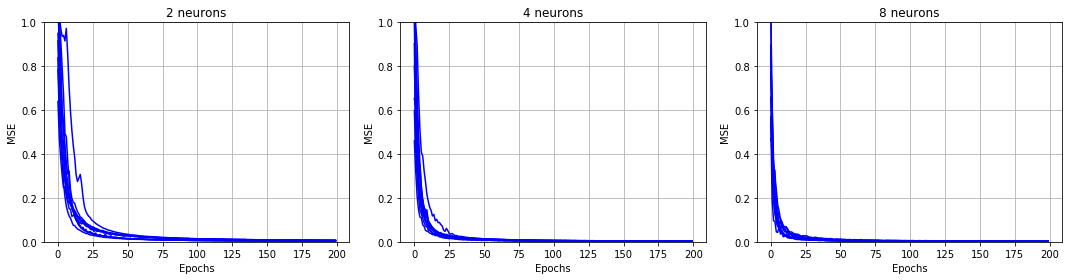

In [79]:
explore_epochs(part4_ar)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...


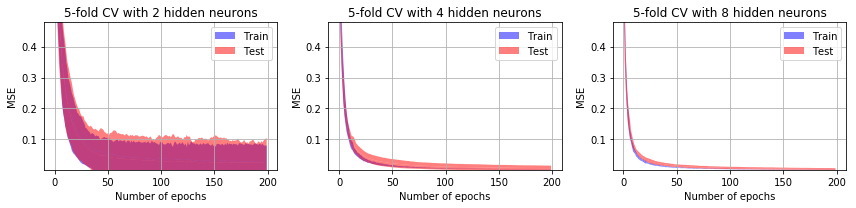

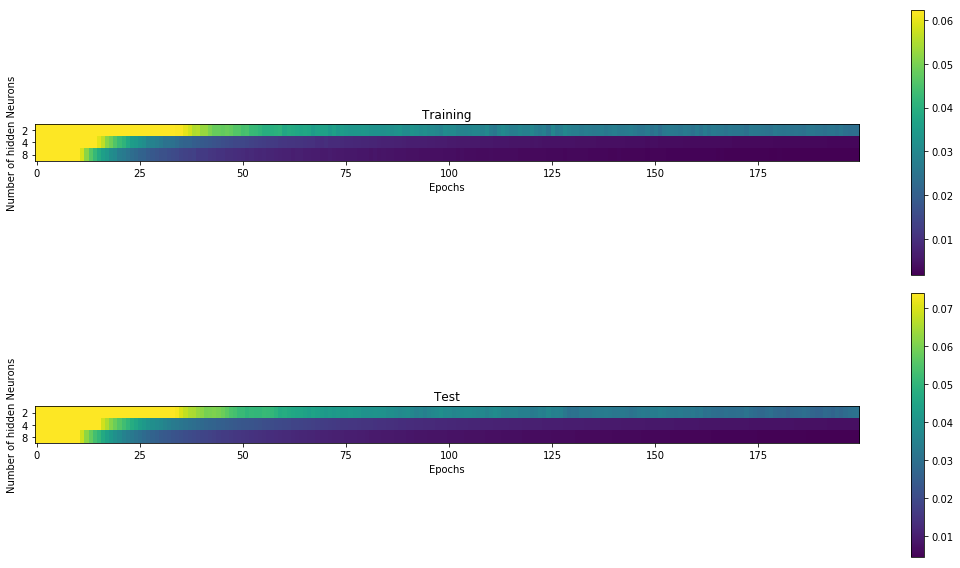

In [80]:
explore_hidden_neurons(part4_ar)

In [83]:
confusion_matrix_kfold(part4_ar)

MSE training:  0.003355824741556989
MSE test:  0.005523358085514745
Confusion matrix:
[[30.  0.]
 [ 0. 30.]]
